In [1]:
from __future__ import print_function
import argparse
import torch
import torch.utils.data
from torch import nn, optim
from torch.nn import functional as F
from torchvision import datasets, transforms
from torchvision.utils import save_image
import os

In [2]:
parser = argparse.ArgumentParser(description='VAE MNIST Example')
parser.add_argument('--batch-size', type=int, default=200, metavar='N',
                    help='input batch size for training (default: 200)')
parser.add_argument('--test-batch-size', type=int, default=128, metavar='N',
                    help='input batch size for testing (default: 128)')
parser.add_argument('--epochs', type=int, default=100, metavar='N',
                    help='number of epochs to train (default: 100)')
parser.add_argument('--no-accel', action='store_true', 
                    help='disables accelerator')
parser.add_argument('--seed', type=int, default=1, metavar='S',
                    help='random seed (default: 1)')
parser.add_argument('--log-interval', type=int, default=10, metavar='N',
                    help='how many batches to wait before logging training status')
parser.add_argument('--latent-dim', type=int, default=4, metavar='N',
                    help='dimensionality of the latent space (default: 2)')
args, _ = parser.parse_known_args()

In [3]:
print(torch.accelerator.is_available())

use_accel = not args.no_accel and torch.accelerator.is_available()

torch.manual_seed(args.seed)


if use_accel:
    device = torch.accelerator.current_accelerator()
else:
    device = torch.device("cpu")

print(f"Using device: {device}")
kwargs = {'num_workers': 0, 'pin_memory': True} if use_accel else {'num_workers': 0}

True
Using device: cuda


/opt/amdgpu/share/libdrm/amdgpu.ids: No such file or directory


In [4]:
train_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=True, download=True,
                   transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
            ])),
    batch_size=args.batch_size, shuffle=True, **kwargs)
test_loader = torch.utils.data.DataLoader(
    datasets.MNIST('../data', train=False, transform=transforms.Compose([
                       transforms.ToTensor(),
                       transforms.Normalize((0.1307,), (0.3081,)),
                       lambda x: x>0,
                       lambda x: x.float(),
                   ])),
    batch_size=args.test_batch_size, shuffle=True, **kwargs)

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.fc1 = nn.Linear(784, 400)
        self.fc21 = nn.Linear(400, args.latent_dim)
        self.fc22 = nn.Linear(400, args.latent_dim)
        self.fc3 = nn.Linear(args.latent_dim, 400)
        self.fc4 = nn.Linear(400, 784)

    def encode(self, x):
        h1 = F.relu(self.fc1(x))
        return self.fc21(h1), self.fc22(h1)

    def reparameterize(self, mu, logvar):
        std = torch.exp(0.5*logvar)
        eps = torch.randn_like(std)
        return mu + eps*std

    def decode(self, z):
        h3 = F.relu(self.fc3(z))
        return torch.sigmoid(self.fc4(h3))

    def forward(self, x):
        mu, logvar = self.encode(x.view(-1, 784))
        z = self.reparameterize(mu, logvar)
        return self.decode(z), mu, logvar

In [6]:
# Reconstruction + KL divergence losses summed over all elements and batch
def loss_function(recon_x, x, mu, logvar):
    BCE = F.binary_cross_entropy(recon_x, x.view(-1, 784), reduction='sum')

    # see Appendix B from VAE paper:
    # Kingma and Welling. Auto-Encoding Variational Bayes. ICLR, 2014
    # https://arxiv.org/abs/1312.6114
    # 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    KLD = -0.5 * torch.sum(1 + logvar - mu.pow(2) - logvar.exp())

    return BCE + KLD * 8.0

In [7]:
model = VAE().to(device)
optimizer = optim.Adam(model.parameters(), lr=1e-3)

def train(epoch):
    model.train()
    train_loss = 0
    for batch_idx, (data, _) in enumerate(train_loader):
        data = data.to(device)
        optimizer.zero_grad()
        recon_batch, mu, logvar = model(data)
        loss = loss_function(recon_batch, data, mu, logvar)
        loss.backward()
        train_loss += loss.item()
        optimizer.step()
        if batch_idx % args.log_interval == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch, batch_idx * len(data), len(train_loader.dataset),
                100. * batch_idx / len(train_loader),
                loss.item() / len(data)), end='\r')

    print('====> Epoch: {} Average loss: {:.4f}'.format(
          epoch, train_loss / len(train_loader.dataset)))


def test(epoch):
    model.eval()
    test_loss = 0
    with torch.no_grad():
        for i, (data, _) in enumerate(test_loader):
            data = data.to(device)
            recon_batch, mu, logvar = model(data)
            test_loss += loss_function(recon_batch, data, mu, logvar).item()

    test_loss /= len(test_loader.dataset)
    print('====> Test set loss: {:.4f}'.format(test_loss))

In [8]:
for epoch in range(1, args.epochs + 1):
    train(epoch)
    test(epoch)

====> Epoch: 1 Average loss: 220.1953ss: 188.972695
====> Test set loss: 191.1348
====> Epoch: 2 Average loss: 189.7687ss: 185.630234
====> Test set loss: 186.8336
====> Epoch: 3 Average loss: 186.2637ss: 182.337363
====> Test set loss: 184.0570
====> Epoch: 4 Average loss: 184.1879ss: 179.959746
====> Test set loss: 182.2618
====> Epoch: 5 Average loss: 182.4670ss: 177.250508
====> Test set loss: 181.0964
====> Epoch: 6 Average loss: 181.3789ss: 178.449453
====> Test set loss: 180.0972
====> Epoch: 7 Average loss: 180.3616ss: 178.673047
====> Test set loss: 179.3056
====> Epoch: 8 Average loss: 179.8584ss: 177.390898
====> Test set loss: 178.6409
====> Epoch: 9 Average loss: 179.2156ss: 180.728848
====> Test set loss: 178.1062
====> Epoch: 10 Average loss: 178.7137ss: 181.352598
====> Test set loss: 177.9606
====> Epoch: 11 Average loss: 178.3474ss: 177.153516
====> Test set loss: 177.5988
====> Epoch: 12 Average loss: 177.8218ss: 177.743105
====> Test set loss: 176.8977
====> Epoch: 

In [9]:
# Save model
torch.save(model, "vae_mnist_model.pth")

/home/arn/Documents/PML/.venv/lib/python3.11/site-packages/torch/functional.py:505: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4381.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


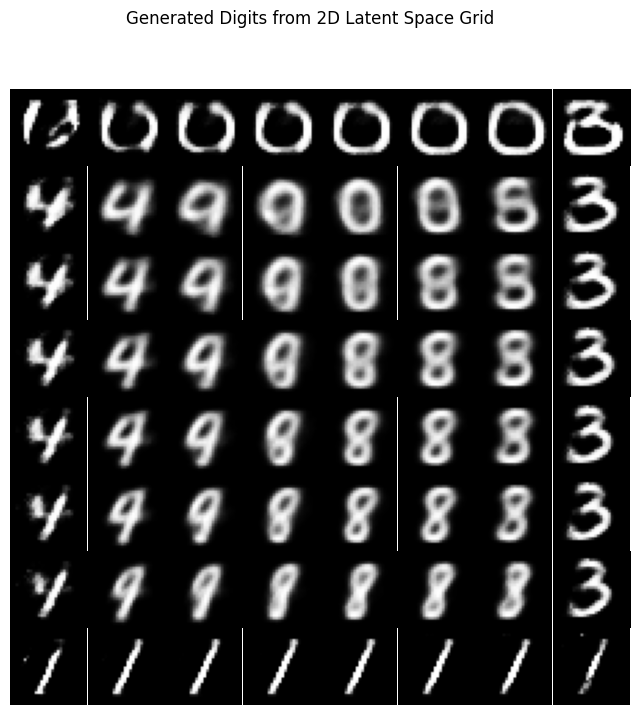

In [10]:
import matplotlib.pyplot as plt

k = 8
epsilon = 1e-6

grid = torch.linspace(0 + epsilon, 1 - epsilon, k)
grid_x, grid_y = torch.meshgrid(grid, grid)

# torch.distributions.normal.Normal.icdf
grid_x = torch.distributions.normal.Normal(0, 1).icdf(grid_x)
grid_y = torch.distributions.normal.Normal(0, 1).icdf(grid_y)

with torch.no_grad():
    sample = torch.zeros((k * k, args.latent_dim))
    sample[:, 0] = grid_x.reshape(-1)
    sample[:, 1] = grid_y.reshape(-1)
    sample = sample.to(device)

    reconstructions = model.decode(sample).view(k * k, 1, 28, 28).cpu()


plt.figure(figsize=(8, 8))
for i in range(k * k):
    plt.subplot(k, k, i + 1)
    plt.imshow(reconstructions[i, 0], cmap='gray')
    plt.axis('off')
plt.subplots_adjust(wspace=0, hspace=0)
plt.suptitle('Generated Digits from 2D Latent Space Grid')
plt.show()